<a href="https://colab.research.google.com/github/lmcanavals/topics/blob/main/0901_pandemic_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on the work of Willy Ugarte

[Paper](https://link.springer.com/chapter/10.1007/978-3-030-71503-8_23)

In [1]:
!pip install ortools 1> /dev/null

In [4]:
from ortools.sat.python import cp_model
from random import randint as rndi
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (40, 15)

In [17]:
n_hospitals = 5
n_patients = 500
n_beds_per_hospitals = [rndi(10, 100) for _ in range(n_hospitals)]
print(n_beds_per_hospitals)
n_beds_total = sum(n_beds_per_hospitals)
print(n_beds_total)

patient_locs = [(rndi(1, 100), rndi(0, 100)) for _ in range(n_patients)]
print(patient_locs)
hospital_locs = [(rndi(1, 100), rndi(0, 100)) for _ in range(n_hospitals)]
print(hospital_locs)
patient_severities = [rndi(1, 5) for _ in range(n_patients)]
print(patient_severities)

[37, 55, 90, 40, 49]
271
[(79, 19), (71, 42), (66, 53), (7, 13), (1, 11), (60, 16), (22, 64), (1, 17), (68, 22), (16, 51), (81, 77), (61, 48), (9, 20), (75, 50), (62, 61), (68, 1), (100, 97), (18, 36), (32, 4), (94, 26), (48, 36), (74, 84), (98, 73), (5, 90), (97, 48), (54, 80), (89, 54), (5, 87), (54, 52), (49, 90), (30, 11), (87, 25), (69, 82), (14, 41), (44, 89), (16, 82), (11, 19), (24, 87), (61, 59), (37, 1), (100, 64), (54, 10), (69, 43), (80, 27), (58, 28), (71, 93), (53, 80), (85, 49), (44, 52), (27, 9), (87, 74), (45, 0), (70, 75), (3, 29), (65, 12), (38, 35), (95, 15), (43, 1), (59, 25), (50, 73), (88, 0), (42, 41), (40, 67), (54, 86), (93, 14), (86, 35), (69, 91), (66, 90), (40, 37), (45, 50), (77, 80), (25, 62), (71, 13), (35, 8), (74, 11), (81, 87), (36, 12), (46, 82), (52, 62), (47, 98), (7, 93), (85, 7), (89, 26), (13, 79), (61, 63), (72, 19), (21, 19), (22, 57), (38, 37), (30, 92), (90, 46), (13, 81), (34, 73), (71, 12), (33, 4), (41, 72), (59, 28), (22, 93), (95, 75), 

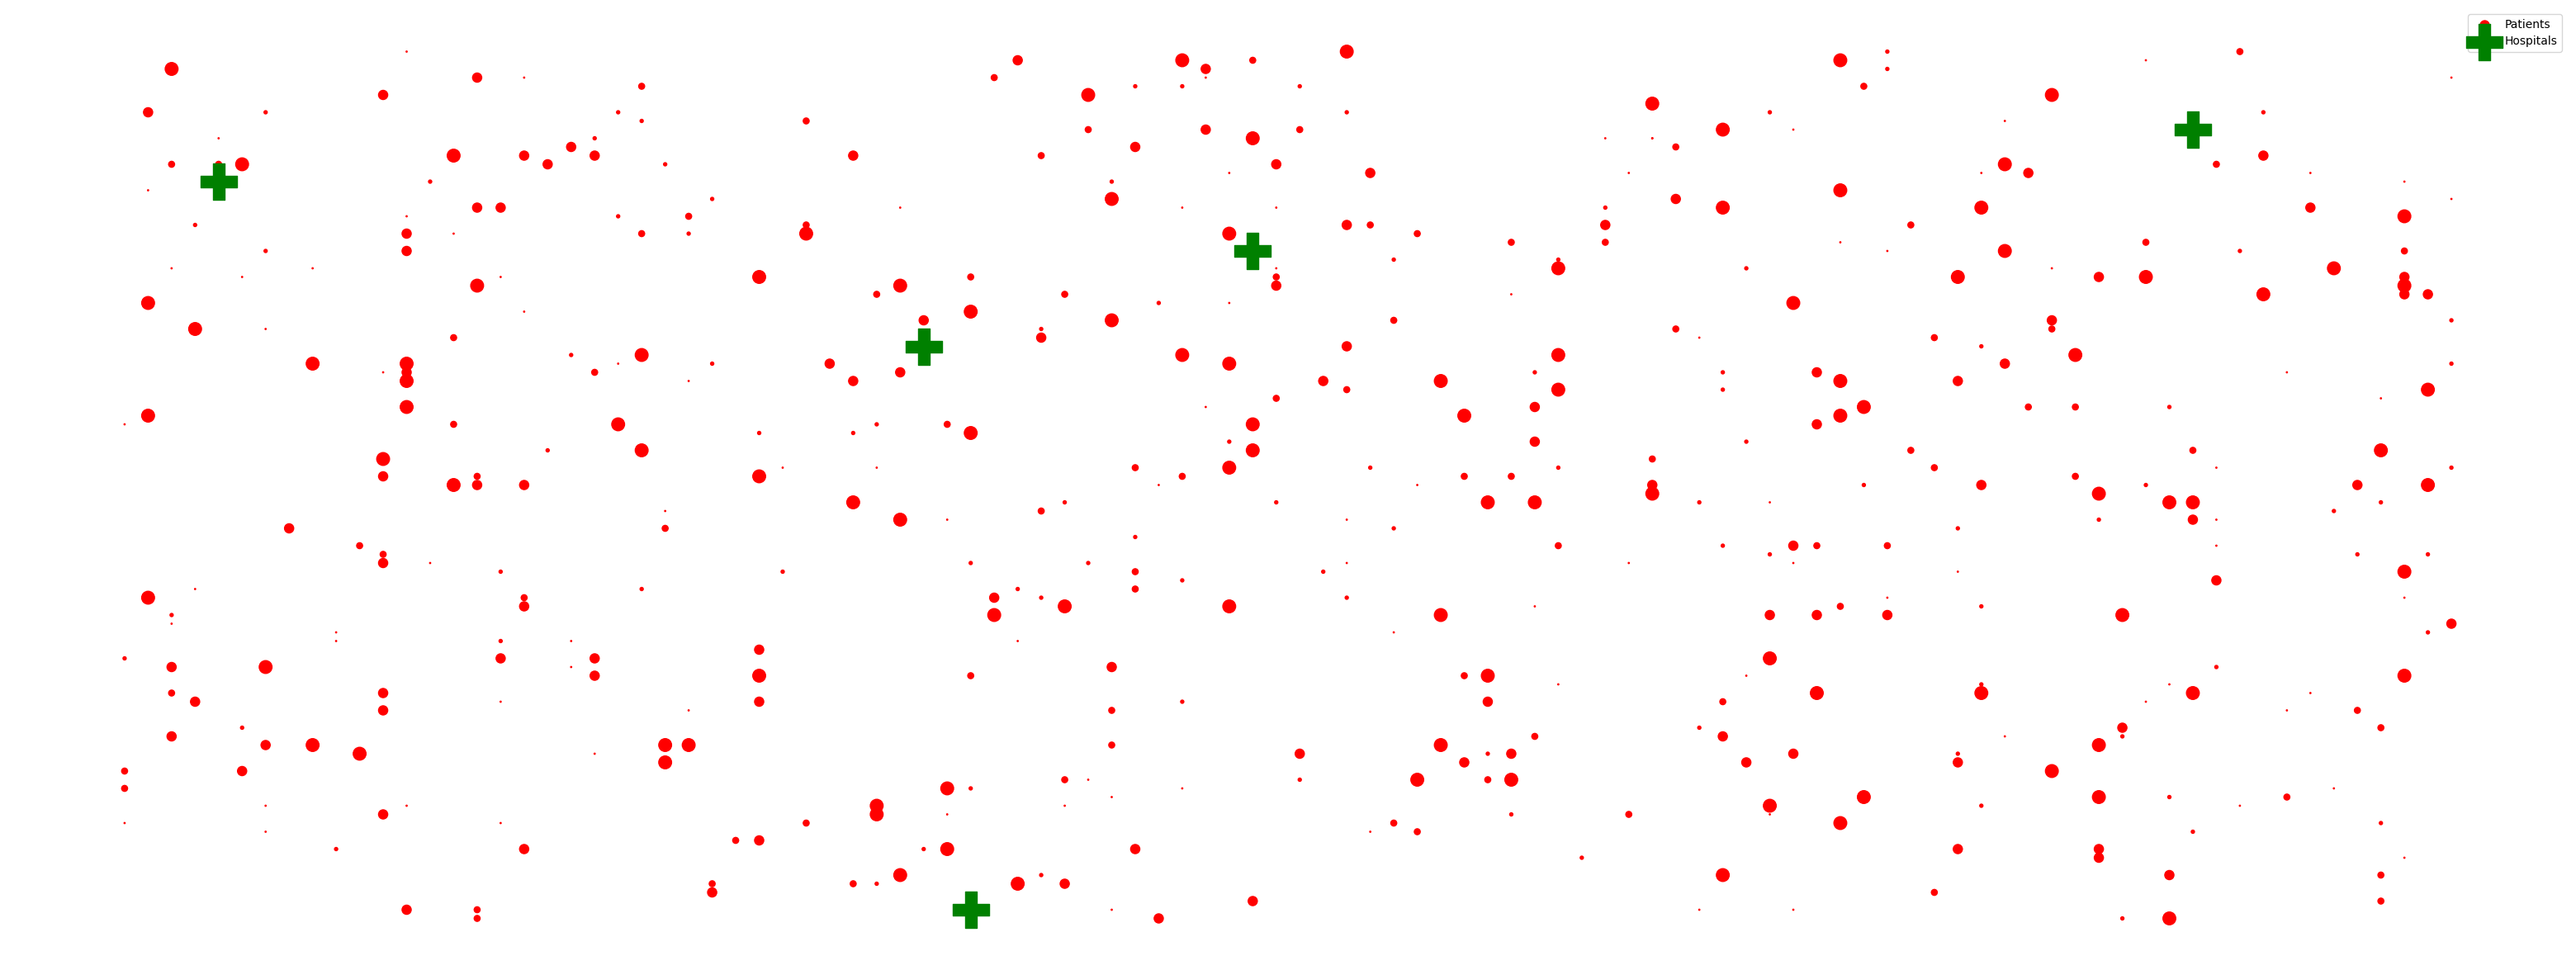

In [18]:
severity_size = [sev**3 for sev in patient_severities]
plt.scatter(*zip(*patient_locs), s=severity_size, c='r', label="Patients")
plt.scatter(*zip(*hospital_locs), s=1000, c='g', marker="P", label="Hospitals")
plt.legend()
plt.axis("off")
plt.show()

In [29]:
model = cp_model.CpModel()

x = {}
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            x[(i, j, k)] = model.NewBoolVar(f"x_{i}_{j}_{k}")

$$
\forall i \in H, \forall j \in B_i,\sum_{k \in P}{x_{ijk}} \le 1
$$

In [31]:
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        model.Add(sum([x[(i, j, k)] for k in range(n_patients)]) <= 1)

$$
\forall k \in P, \sum_{i\in H}\sum_{j\in B_i}x_{ijk} \le 1
$$

In [30]:
for k in range(n_patients):
    n_pat_per_bed_hosp = []
    for i in range(n_hospitals):
        n_pat_per_bed_hosp.append(sum(x[(i,j,k)] for j in
                                      range(n_beds_per_hospitals[i])))
        model.Add(sum(n_pat_per_bed_hosp) <= 1)

$$
\max_{sol}{\sum_{i \in H}{\sum_{j \in B_i}{\sum_{k \in P}{x_{ijk}}}}}
$$

In [32]:
def dist(p1, p2):
    return int(((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5)

max_dist = 0
for i in range(n_hospitals):
    for k in range(n_patients):
        d = dist(hospital_locs[i], patient_locs[k])
        if max_dist < d:
            max_dist = d

In [34]:
pref = []
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            pref += [x[(i,j,k)]*(100 - 100*dist(patient_locs[k], hospital_locs[i]) / max_dist + 100 * patient_severities[k] / 5)]
model.Maximize(sum(pref))

# IT'S SOLVING TIME!

In [35]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status == cp_model.OPTIMAL:
    print("Time:", solver.WallTime())
    for i in range(n_hospitals):
        print(f"Hospital {i+1} {hospital_locs[i]}, has {n_beds_per_hospitals[i]} beds")
        for j in range(n_beds_per_hospitals[i]):
            for k in range(n_patients):
                if solver.Value(x[(i,j,k)]):
                    print(f"\tPatient {k+1} in bed {j+1}")
    print()

Time: 52.744283877
Hospital 1 (89, 91), has 37 beds
	Patient 308 in bed 1
	Patient 249 in bed 2
	Patient 414 in bed 3
	Patient 479 in bed 4
	Patient 434 in bed 5
	Patient 252 in bed 6
	Patient 274 in bed 7
	Patient 11 in bed 8
	Patient 181 in bed 9
	Patient 51 in bed 10
	Patient 395 in bed 11
	Patient 357 in bed 12
	Patient 100 in bed 13
	Patient 102 in bed 14
	Patient 188 in bed 15
	Patient 335 in bed 16
	Patient 259 in bed 17
	Patient 261 in bed 18
	Patient 403 in bed 19
	Patient 22 in bed 20
	Patient 23 in bed 21
	Patient 189 in bed 22
	Patient 71 in bed 23
	Patient 208 in bed 24
	Patient 104 in bed 25
	Patient 383 in bed 26
	Patient 76 in bed 27
	Patient 373 in bed 28
	Patient 459 in bed 29
	Patient 182 in bed 30
	Patient 185 in bed 31
	Patient 453 in bed 32
	Patient 139 in bed 33
	Patient 221 in bed 34
	Patient 310 in bed 35
	Patient 356 in bed 36
	Patient 444 in bed 37
Hospital 2 (37, 1), has 55 beds
	Patient 162 in bed 1
	Patient 436 in bed 2
	Patient 336 in bed 3
	Patient 73 in

In [36]:
plot_lines = [[] for _ in range(n_hospitals)]
for i in range(n_hospitals):
    for j in range(n_beds_per_hospitals[i]):
        for k in range(n_patients):
            if solver.Value(x[(i,j,k)]):
                abcise_line = [hospital_locs[i][0], patient_locs[k][0]]
                ordered_line = [hospital_locs[i][1], patient_locs[k][1]]
                plot_lines[i].append([abcise_line, ordered_line])

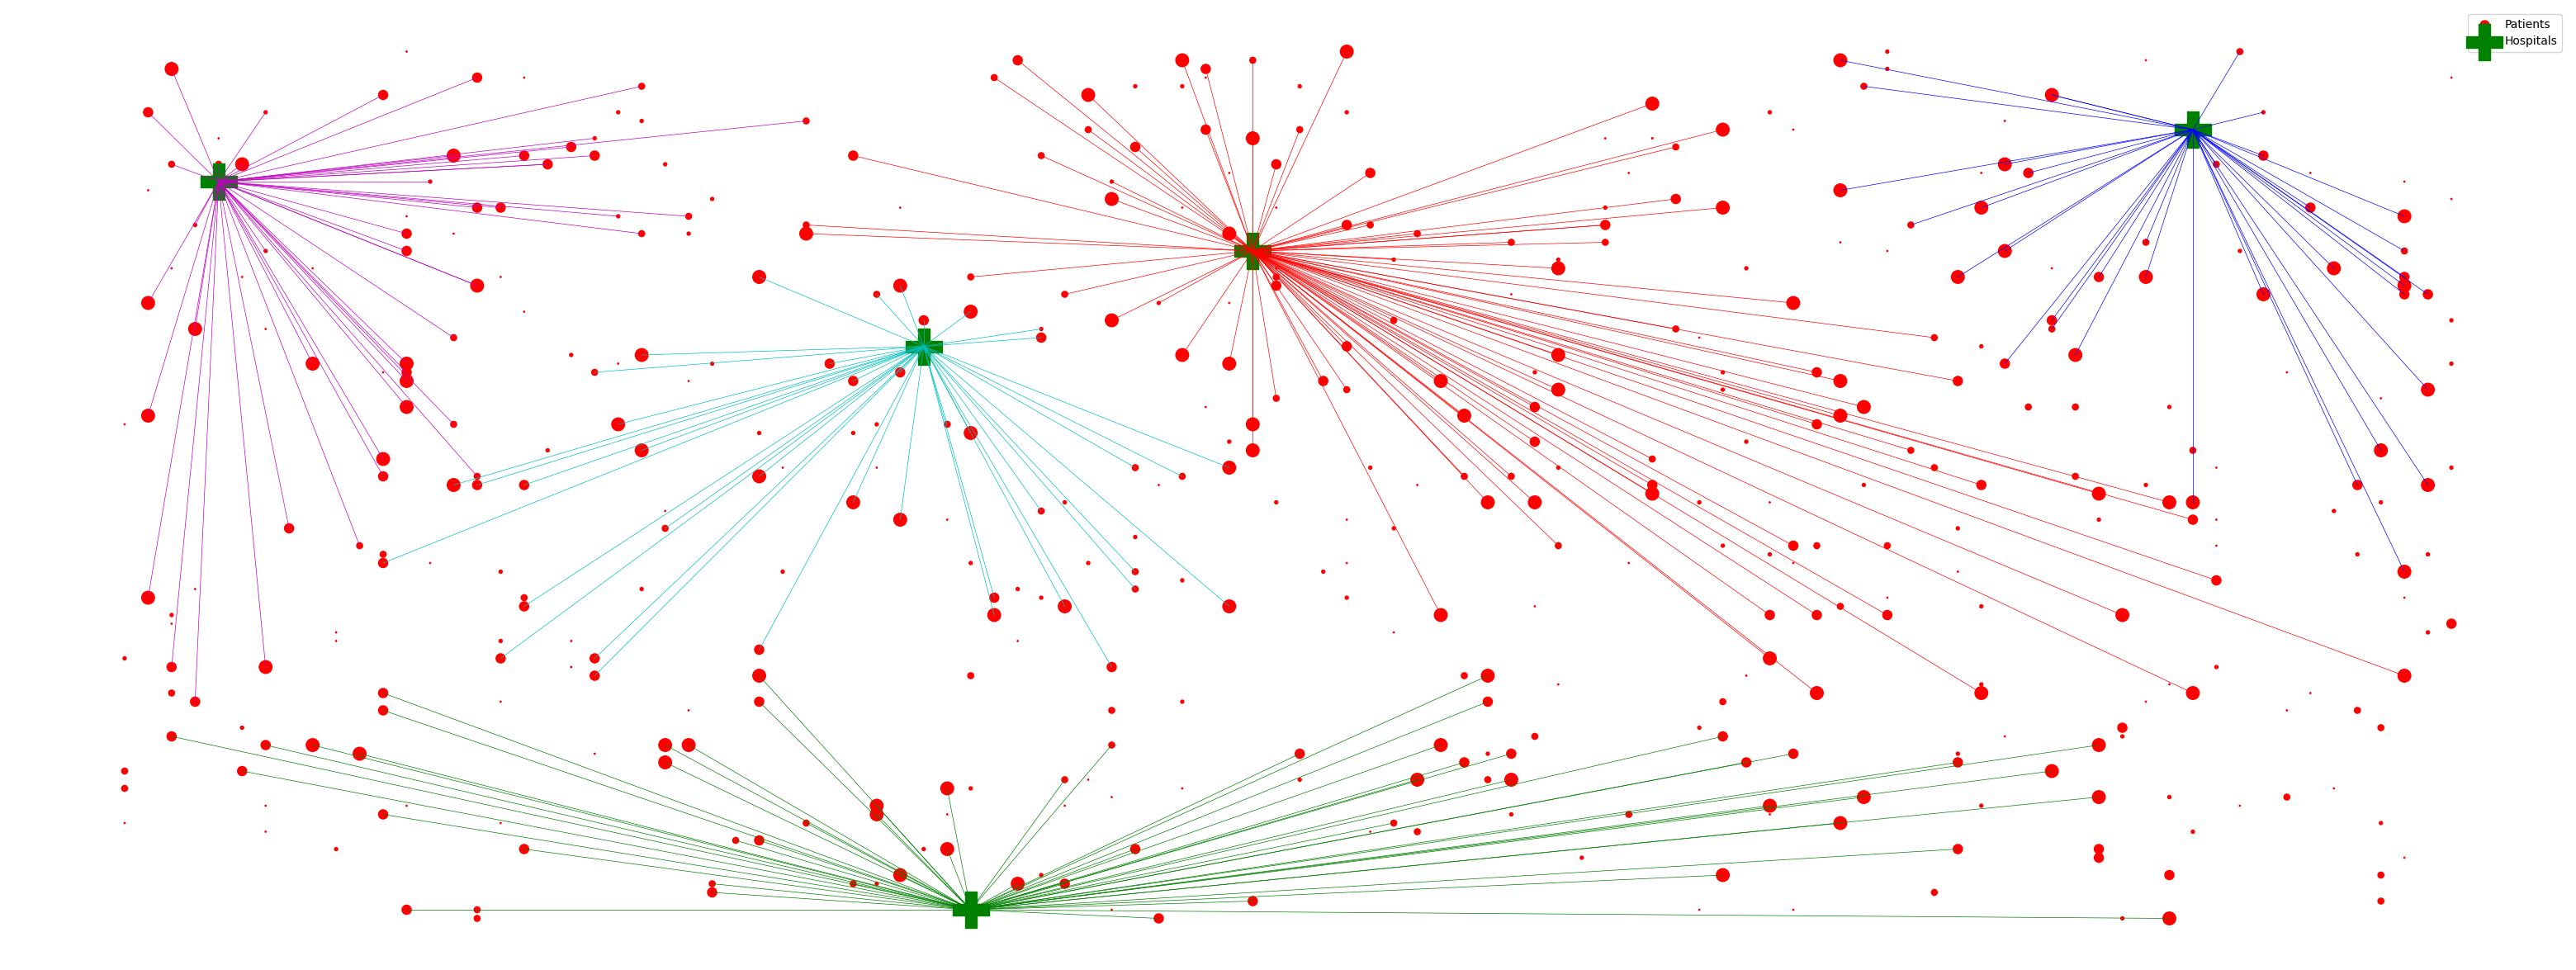

In [39]:
from itertools import cycle

colors = cycle("bgrcmk")
for i in range(n_hospitals):
    c = next(colors)
    for x, y in plot_lines[i]:
        plt.plot(x, y, c=c, linewidth=.5)
plt.scatter(*zip(*patient_locs), s=severity_size, c='r', label="Patients")
plt.scatter(*zip(*hospital_locs), s=1000, c='g', marker="P", label="Hospitals")
plt.legend()
plt.axis("off")
plt.show()